In [1]:
import pandas as pd #Data manipulation
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import matplotlib.pyplot as plt # Visualization    #evalution
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.exceptions import UndefinedMetricWarning
import warnings
# Preprocessing
feature_names = ['Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Max. Voltage Dischar. (V)',
                 'Min. Voltage Charg. (V)', 'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)']
target_name = 'RUL'

In [2]:
# Load dataset from CSV file
df = pd.read_csv('Battery_RUL.csv')
# Split dataset into features and target variable
X = df[feature_names]
y = df[target_name]

In [3]:
# Apply MinMaxScaler => normalizing the data and ensuring that all features contribute equally to the learning process
sc = MinMaxScaler()
X = sc.fit_transform(X) #scaling
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#generalization
# Create the SVM model
model = SVR(kernel="rbf", C=10000, gamma=0.5, epsilon=0.001) #relation x,y
model.fit(X_train, y_train)
# Make predictions on the test set
y_predictions = model.predict(X_test)

In [4]:
# Calculate performance metrics for the test set
r_squared = r2_score(y_test, y_predictions)
rmse = mean_squared_error(y_test, y_predictions, squared=False)
accuracy = accuracy_score(y_test, np.round(y_predictions))  # assuming RUL is a regression problem
# Print performance metrics for the test set before cross-validation
print('Test Set Metrics (Before Cross-Validation):')
print('R-squared: {:.2%}'.format(r_squared))
print('Root Mean Squared Error: {:.2f}'.format(rmse))
print('Accuracy: {:.2%}'.format(accuracy))

Test Set Metrics (Before Cross-Validation):
R-squared: 93.09%
Root Mean Squared Error: 84.59
Accuracy: 0.70%


In [5]:
# Perform cross-validation
# k-fold cross-validation
cv_results = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
# Print cross-validation results
print("\nCross-Validation Results:")
print("Mean RMSE:", np.sqrt(-cv_results.mean()))
print("Std RMSE:", np.sqrt(cv_results.std()))


Cross-Validation Results:
Mean RMSE: 83.87976119209665
Std RMSE: 43.501474546372755


In [6]:
# Calculate the margin
margin = model._decision_function(X_test)
print('Margin: {:.2f}'.format(margin.mean()))

Margin: 540.96


In [7]:
# Create bins for actual and predicted values for the test set
bins = np.linspace(min(y_test.min(), y_predictions.min()), max(y_test.max(), y_predictions.max()), 10)
y_test_binned = np.digitize(y_test, bins)
y_pred_binned = np.digitize(y_predictions, bins)
# Calculate confusion matrix for test set
confusion_mat_test = confusion_matrix(y_test_binned, np.round(y_pred_binned))
# Suppress UndefinedMetricWarning for recall
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    # Calculate accuracy, precision, recall, and F-measure for test set
    accuracy = accuracy_score(y_test_binned, y_pred_binned)
    precision = precision_score(y_test_binned, y_pred_binned, average='weighted', zero_division=1)
    recall = recall_score(y_test_binned, y_pred_binned, average='weighted', zero_division=1)
    f1 = f1_score(y_test_binned, y_pred_binned, average='weighted', zero_division=1)
# Print classification metrics for test set
print('\nClassification Metrics (Test Set):')
print('Accuracy: {:.2%}'.format(accuracy))
print('Precision: {:.2%}'.format(precision))
print('Recall: {:.2%}'.format(recall))
print('F-measure: {:.2%}'.format(f1))


Classification Metrics (Test Set):
Accuracy: 85.36%
Precision: 85.92%
Recall: 85.36%
F-measure: 85.42%


In [8]:
# Print confusion matrix for test set
print("\nConfusion Matrix (Test Set):")
print(confusion_mat_test)


Confusion Matrix (Test Set):
[[  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   1 511 117   0   0   0   0]
 [  0   0  86 854  66   0   1   0]
 [  0   0   0  63 871  10   0   0]
 [  1   0   0   0  93 336   2   1]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]


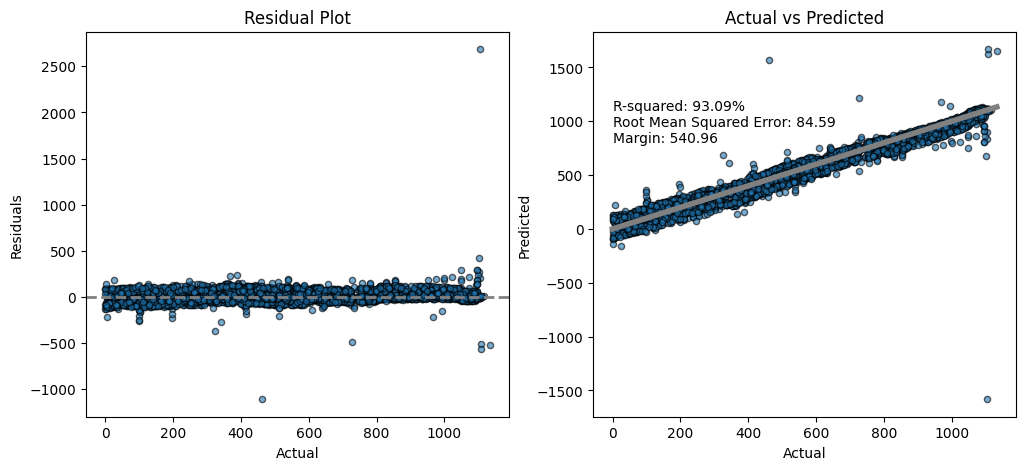

In [9]:
# Residual Plot
residuals = y_test - y_predictions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, residuals, s=20, alpha=0.6, linewidth=1, edgecolor='black')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Actual')
plt.ylabel('Residuals')
# Actual vs Predicted Plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_predictions, s=20, alpha=0.6, linewidth=1, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linewidth=4, color='gray')
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.annotate(text=('R-squared: {:.2%}'.format(r_squared) + '\n' +
                    'Root Mean Squared Error: {:.2f}'.format(rmse) + '\n' +
                    'Margin: {:.2f}'.format(margin.mean())),
             xy=(0, 800),
             size='medium')
plt.show()